In [1]:
# -*- coding: utf-8 -*-

# Curso de Atualização Python (USP ESALQ)

# Prof. Helder Prado
# Prof. Wilson Tarantin Jr.

# Exercício: Variável Y categórica com 3 ou mais categorias

## Importando os pacotes necessários

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV


In [3]:
## Carregando o dataset
## Fonte: adaptado de https://www.kaggle.com/datasets/prathamtripathi/customersegmentation?select=Telecust1.csv

df = pd.read_csv("segmenta_telecom.csv")

In [6]:
df.head(2)

,regiao,meses_cliente,idade,casado,anos_emprego,aposentado,masculino,categoria
0,regiao_b,13,44,1,5,0,0,A
1,regiao_c,11,33,1,5,0,0,D


In [9]:
df.tail(2)

,regiao,meses_cliente,idade,casado,anos_emprego,aposentado,masculino,categoria
998,regiao_c,70,49,0,22,0,1,C
999,regiao_c,50,36,1,3,0,1,B


In [4]:
## Informações das variáveis quanti_contagem

print(df[['meses_cliente', 'idade', 'anos_emprego']].describe())

       meses_cliente        idade  anos_emprego
count    1000.000000  1000.000000   1000.000000
mean       35.526000    41.684000     10.987000
std        21.359812    12.558816     10.082087
min         1.000000    18.000000      0.000000
25%        17.000000    32.000000      3.000000
50%        34.000000    40.000000      8.000000
75%        54.000000    51.000000     17.000000
max        72.000000    77.000000     47.000000


In [7]:
print(df['regiao'].value_counts())
print(df['casado'].value_counts())
print(df['aposentado'].value_counts())
print(df['masculino'].value_counts())

regiao_c    344
regiao_b    334
regiao_a    322
Name: regiao, dtype: int64
0    505
1    495
Name: casado, dtype: int64
0    953
1     47
Name: aposentado, dtype: int64
1    517
0    483
Name: masculino, dtype: int64


In [8]:
print(df['categoria'].value_counts())

C    281
A    266
D    236
B    217
Name: categoria, dtype: int64


In [10]:
## Transformando variáveis categóricas em dummies

df = pd.get_dummies(df, columns=['regiao'])

In [11]:
df.head(2)

,meses_cliente,idade,casado,anos_emprego,aposentado,masculino,categoria,regiao_regiao_a,regiao_regiao_b,regiao_regiao_c
0,13,44,1,5,0,0,A,0,1,0
1,11,33,1,5,0,0,D,0,0,1


In [12]:
## Separando as variáveis Y e X

X = df.drop(columns=['categoria']).values
y = df['categoria'].values

In [13]:
## Coletar os nomes das variáveis X

features = list(df.drop(columns=['categoria']).columns)

In [14]:
## Criando amostras de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Bagging

In [15]:
## 1: Para fins de comparação, estima-se uma árvore de classificação

tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [16]:
# Predict do modelo de uma árvore
y_pred_tree = tree_clf.predict(X_test)

In [17]:
# Matriz de classificação para uma árvore
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           A       0.38      0.40      0.39        60
           B       0.30      0.46      0.36        39
           C       0.44      0.22      0.29        55
           D       0.16      0.17      0.17        46

    accuracy                           0.31       200
   macro avg       0.32      0.31      0.30       200
weighted avg       0.33      0.31      0.31       200



In [18]:
#%% 2: Estimando um modelo bagging com base em árvores de classificação

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4), # modelo base: árvore de classificação
    n_estimators=500,
    max_samples=50,
    bootstrap=True, # bootstrap = True indica modelo Bagging / False = Pasting
    n_jobs=-1, # utiliza todos os núcleos do computador
    random_state=42) 

bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=50, n_estimators=500, n_jobs=-1, random_state=42)

In [19]:
# Predict do modelo bagging de árvores
y_pred_bag = bag_clf.predict(X_test)

In [25]:
# Gerando a matriz de confusão

cm = confusion_matrix(y_test, 
                      y_pred_bag, 
                      labels=bag_clf.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=bag_clf.classes_)


In [26]:
# Matriz de classificação do modelo bagging de árvores
print(classification_report(y_test, y_pred_bag))

              precision    recall  f1-score   support

           A       0.42      0.47      0.44        60
           B       0.38      0.36      0.37        39
           C       0.40      0.56      0.47        55
           D       0.17      0.07      0.09        46

    accuracy                           0.38       200
   macro avg       0.34      0.36      0.34       200
weighted avg       0.35      0.38      0.35       200



In [27]:
#%% 3: Para fins de comparação, estima-se um modelo logístico

reg_log = LogisticRegression()
reg_log.fit(np.delete(X_train, -1, axis=1), y_train)

/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [28]:
# Predict do modelo logístico
y_pred_reg_log = reg_log.predict(np.delete(X_test, -1, axis=1))

# Matriz de classificação do modelo logístico
print(classification_report(y_test, y_pred_reg_log))

              precision    recall  f1-score   support

           A       0.40      0.50      0.44        60
           B       0.40      0.46      0.43        39
           C       0.43      0.47      0.45        55
           D       0.21      0.09      0.12        46

    accuracy                           0.39       200
   macro avg       0.36      0.38      0.36       200
weighted avg       0.36      0.39      0.37       200



In [29]:
#%% 4: Estimando um modelo bagging com base em uma logística

bag_log = BaggingClassifier(
    LogisticRegression(), # modelo base: logística
    n_estimators=500,
    max_samples=50,
    bootstrap=True, # bootstrap = True indica modelo Bagging / False = Pasting
    n_jobs= -1, # utiliza todos os núcleos do computador
    random_state=42) 

bag_log.fit(np.delete(X_train, -1, axis=1), y_train)

/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/dumoura/opt/anaconda3/envs/python3.8-control/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

BaggingClassifier(base_estimator=LogisticRegression(), max_samples=50,
                  n_estimators=500, n_jobs=-1, random_state=42)

In [30]:
# Predict do modelo bagging de logística
y_pred_log = bag_log.predict(np.delete(X_test, -1, axis=1))

# Matriz de classificação do modelo bagging de logística
print(classification_report(y_test, y_pred_log))


              precision    recall  f1-score   support

           A       0.38      0.47      0.42        60
           B       0.38      0.49      0.43        39
           C       0.42      0.51      0.46        55
           D       0.30      0.07      0.11        46

    accuracy                           0.39       200
   macro avg       0.37      0.38      0.35       200
weighted avg       0.37      0.39      0.36       200



In [31]:
#%% Avaliação out-of-bag

# As observações de treinamento que não são amostradas são "out-of-bag"
# O modelo pode ser avaliado nessas observações sem a necessidade de um conjunto de validação
# Trata-se de uma avaliação automática após o treinamento

bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(max_depth=4), 
    n_estimators=500,
    max_samples=50,
    bootstrap=True,
    n_jobs=-1, 
    oob_score=True, # avaliação out-of-bag
    random_state=42) 

bag_clf_oob.fit(X, y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                  max_samples=50, n_estimators=500, n_jobs=-1, oob_score=True,
                  random_state=42)

In [32]:
# Acurácia do modelo
print(bag_clf_oob.oob_score_)

0.373


In [33]:
#%% Random Forests

# O ForestClassifier é mais otimizado para árvores de decisão

rnd_clf = RandomForestClassifier(n_estimators=500, max_depth=4, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [34]:
# Predict na base de teste
y_pred_rf = rnd_clf.predict(X_test)

In [35]:
# Matriz de classificação
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           A       0.39      0.52      0.45        60
           B       0.33      0.23      0.27        39
           C       0.38      0.56      0.46        55
           D       0.23      0.07      0.10        46

    accuracy                           0.37       200
   macro avg       0.33      0.34      0.32       200
weighted avg       0.34      0.37      0.34       200



In [36]:
# Importância das variáveis X

for name, score in zip(features, rnd_clf.feature_importances_):
    print(name, score)

meses_cliente 0.4192013469459284
idade 0.16964750868685946
casado 0.044748066336576776
anos_emprego 0.2335458598282824
aposentado 0.023505185143206903
masculino 0.030714195682323198
regiao_regiao_a 0.026490332404839136
regiao_regiao_b 0.025840816345688567
regiao_regiao_c 0.02630668862629501


In [49]:
#%% Classificadores de Votação

tree_clf_vot = DecisionTreeClassifier(max_depth=4, random_state=42)
rnd_clf_vot = RandomForestClassifier(max_depth=4, random_state=42)


In [50]:
#%% Parametrizando o classificador

voting_clf = VotingClassifier(
    estimators=[('tree', tree_clf_vot),
                ('rf', rnd_clf_vot)],
    voting='soft') #hard or soft

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('tree',
                              DecisionTreeClassifier(max_depth=4,
                                                     random_state=42)),
                             ('rf',
                              RandomForestClassifier(max_depth=4,
                                                     random_state=42))],
                 voting='soft')

In [51]:
# Fazendo o predict e identificando a acurácia dos classificadores
for clf in (tree_clf_vot, rnd_clf_vot, voting_clf):
    clf.fit(X_train, y_train)
    y_pred_vot = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred_vot))

DecisionTreeClassifier 0.31
RandomForestClassifier 0.375
VotingClassifier 0.38


In [42]:
#%% Boosting
#%% AdaBoost

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=4),
    n_estimators=100,
    algorithm='SAMME.R',
    learning_rate=0.1)

ada_clf.fit(X_train,y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.1, n_estimators=100)

In [43]:
# Predict na base de teste
y_pred_ada = ada_clf.predict(X_test)

In [44]:
# Matriz de classificação
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           A       0.37      0.28      0.32        60
           B       0.27      0.23      0.25        39
           C       0.31      0.42      0.36        55
           D       0.26      0.26      0.26        46

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.31      0.30      0.30       200



In [45]:
#%% Grid search para escolha da profundidade 

gs_ada = GridSearchCV(estimator=DecisionTreeClassifier(),
                          param_grid={
                              'max_depth': [2, 3, 4, 5, 6, 7 , 8, 9, 10, None],
                          },
                          cv=5,
                          return_train_score=False,
                          scoring='accuracy')

gs_ada.fit(X=X_train, y=y_train)

resultados_gs_ada = pd.DataFrame(gs_ada.cv_results_).set_index('rank_test_score').sort_index()

print(resultados_gs_ada)

                 mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
rank_test_score                                                                 
1                     0.001530      0.000275         0.000414        0.000065   
2                     0.002159      0.000312         0.000716        0.000207   
3                     0.002244      0.000637         0.000640        0.000194   
4                     0.001832      0.000358         0.000508        0.000095   
5                     0.002438      0.000488         0.000643        0.000090   
6                     0.001246      0.000346         0.000475        0.000096   
7                     0.001913      0.000181         0.000481        0.000143   
8                     0.002228      0.000298         0.000500        0.000138   
8                     0.002314      0.000152         0.000451        0.000163   
10                    0.002266      0.000703         0.000852        0.000799   

                param_max_d

[0.3925  0.43625 0.45625 0.4775  0.49    0.515   0.545   0.5425  0.55
 0.56    0.56375 0.56    0.58    0.58375 0.5925  0.595   0.61125 0.61625
 0.615   0.62375 0.62875 0.6475  0.64875 0.65875 0.6575  0.6575  0.6725
 0.6825  0.67875 0.67375 0.675   0.68    0.68875 0.695   0.69125 0.69125
 0.6975  0.70375 0.71375 0.71125 0.71875 0.71625 0.7225  0.7375  0.75
 0.7475  0.755   0.75375 0.76125 0.76125 0.7625  0.7675  0.7625  0.76
 0.77    0.7825  0.785   0.79    0.78625 0.78    0.7825  0.7825  0.78125
 0.78125 0.79    0.79375 0.79875 0.80625 0.81375 0.81625 0.815   0.81375
 0.81375 0.81625 0.81375 0.81125 0.81625 0.82    0.8175  0.82125 0.81875
 0.82625 0.82875 0.83    0.835   0.8475  0.84875 0.85125 0.85125 0.8575
 0.85375 0.855   0.8625  0.8725  0.88    0.88625 0.88875 0.89375 0.895
 0.89375]
[0.3925  0.43625 0.45625 0.4775  0.49    0.515   0.545   0.5425  0.55
 0.56    0.56375 0.56    0.58    0.58375 0.5925  0.595   0.61125 0.61625
 0.615   0.62375 0.62875 0.6475  0.64875 0.65875 0.6575  

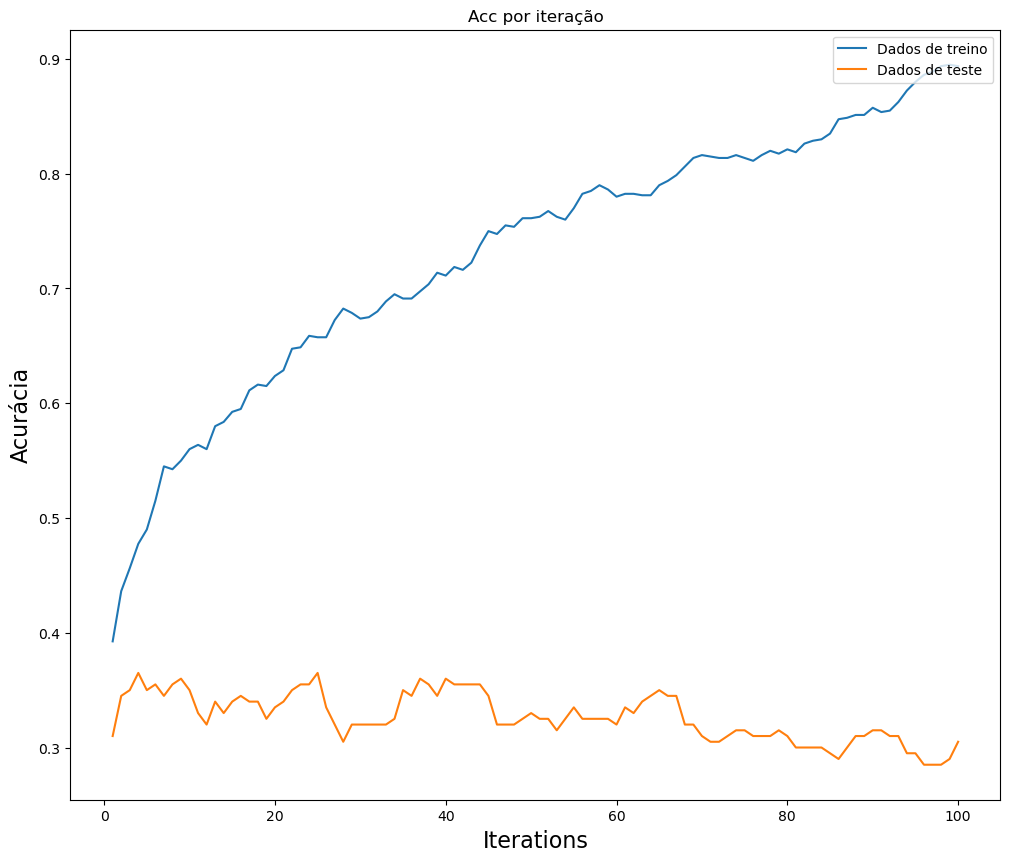

In [53]:
#%% Lista com cada iteração

estimators = np.arange(1,101)

#%% Lista que vai receber cada resultado das iterações

scores_train = np.zeros(100, dtype=np.float64)

scores_test = np.zeros(100, dtype=np.float64)

#%% Coletando a acurácia de cada iteração nos dados de treino

from sklearn.metrics import accuracy_score

for i, y_pred in enumerate(ada_clf.staged_predict(X_train)):
    
    acc = accuracy_score(y_train, y_pred)
    
    scores_train[i] = acc
    
print(scores_train)
    
#%% Coletando a acurácia de cada iteração nos dados de teste

for i, y_pred in enumerate(ada_clf.staged_predict(X_test)):
    
    acc = accuracy_score(y_test, y_pred)
    
    scores_test[i] = acc
    
print(scores_train)
    
#%% Visualizando a acurácia ao longo de cada iteração

plt.figure(figsize=(12, 10))
plt.title("Acc por iteração")
plt.plot(estimators, scores_train, label='Dados de treino')
plt.plot(estimators, scores_test, label='Dados de teste')
plt.legend(loc="upper right")
plt.xlabel("Iterations", fontsize=16)
plt.ylabel("Acurácia", fontsize=16)
plt.show()

**Obs**.

- classico overfeeting - grande/crescente acurancia no treino e pequeno/descrescente no teste
- ficar no primeiro pico da acuracia -> por volta de 3

In [54]:
#%% Parametrizando o AdaBoost com base nas análise anteriores

ada_clf_best = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=3), # 3 profundidades
    n_estimators=3, # ver obs do gra
    algorithm='SAMME.R',
    learning_rate=0.1)

ada_clf_best.fit(X_train,y_train)


ValueError: Unknown label type: 'unknown'

In [55]:
# Predict na base de teste
y_pred_ada_best = ada_clf_best.predict(X_test)

In [56]:
# Matriz de classificação
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           A       0.37      0.28      0.32        60
           B       0.27      0.23      0.25        39
           C       0.31      0.42      0.36        55
           D       0.26      0.26      0.26        46

    accuracy                           0.30       200
   macro avg       0.30      0.30      0.30       200
weighted avg       0.31      0.30      0.30       200



In [57]:
#%% Gradiente Boosting

gbc = GradientBoostingClassifier(max_depth=3, n_estimators=100, learning_rate=0.1, random_state=42)
gbc.fit(X_train, y_train)

y_pred_gbc = gbc.predict(X_test)

ValueError: Unknown label type: 'unknown'

In [58]:
# Matriz de classificação
print(classification_report(y_test, y_pred_gbc))


              precision    recall  f1-score   support

           A       0.40      0.38      0.39        60
           B       0.29      0.31      0.30        39
           C       0.38      0.44      0.40        55
           D       0.11      0.09      0.10        46

    accuracy                           0.32       200
   macro avg       0.29      0.30      0.30       200
weighted avg       0.30      0.32      0.31       200



In [59]:
#%% XGBoost

labels = np.unique(y)

for index, item in enumerate(labels):
   y_train[y_train == item] = index 
   
for index, item in enumerate(labels):
   y_test[y_test == item] = index 

xgb_clf = xgboost.XGBClassifier(max_depth=3, n_estimators=100, random_state=42)

xgb_clf.fit(X_train, y_train)

y_pred_xgb = xgb_clf.predict(X_test)

# Matriz de classificação
print(classification_report(y_test.astype("int"), y_pred_xgb))

              precision    recall  f1-score   support

           0       0.33      0.32      0.32        60
           1       0.29      0.31      0.30        39
           2       0.36      0.38      0.37        55
           3       0.14      0.13      0.13        46

    accuracy                           0.29       200
   macro avg       0.28      0.28      0.28       200
weighted avg       0.29      0.29      0.29       200

